# Support for XGBoost, LightGBM, CatBoost — Issue #92

This notebook demonstrates using `calibrated-explanations` with popular scikit-learn compatible libraries:
- XGBoost (`xgboost.XGBClassifier`)
- LightGBM (`lightgbm.LGBMClassifier`)
- CatBoost (`catboost.CatBoostClassifier`)

The `CalibratedExplainer` is model-agnostic: it only requires a fitted learner exposing `predict_proba` (classification) or `predict` (regression).

Each section below is a small, self-contained example using a tiny synthetic dataset. If a library is not installed, its section will gracefully skip with a message.

In [1]:
# Optional: install third-party libraries if running on a fresh environment
RUN_INSTALL = False  # set to True to install via pip from this notebook

if RUN_INSTALL:
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'xgboost', 'lightgbm', 'catboost', 'scikit-learn'])

# Make the repository 'src' importable if running this notebook from a local clone
import os, sys
repo_src = os.path.abspath(os.path.join('..', 'src'))
if repo_src not in sys.path:
    sys.path.insert(0, repo_src)

import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from calibrated_explanations.core.calibrated_explainer import CalibratedExplainer

np.random.seed(42)

def make_tiny_binary(n_samples=200, n_features=8, random_state=42):
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=max(2, n_features // 3),
        n_redundant=0, n_repeated=0, n_classes=2, random_state=random_state
    )
    X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    X_train, X_cal, y_train, y_cal = train_test_split(X_tmp, y_tmp, test_size=0.25, random_state=random_state)  # 0.25 * 0.8 = 0.2
    return X_train, y_train, X_cal, y_cal, X_test, y_test


C:\Users\loftuw\CUDATemp\ipykernel_41724\2734101134.py:18: DeprecationWarning: The legacy module 'calibrated_explanations.core' is deprecated; import from the 'calibrated_explanations.core' package instead.
  from calibrated_explanations.core.calibrated_explainer import CalibratedExplainer


## XGBoost (XGBClassifier)

XGBoost proba_uncal shape: (40, 2)
XGBoost proba_cal shape: (40, 2)
XGBoost first 3 calibrated probs: [0.08333333 0.29411765 0.83333333]
XGBoost first 3 intervals: [(0.0, 0.09090909090909091), (0.2, 0.3333333333333333), (0.8260869565217391, 0.8695652173913043)]
XGBoost first 10 calibrated predictions: ['0' '0' '1' '0' '1' '0' '1' '0' '1' '1']


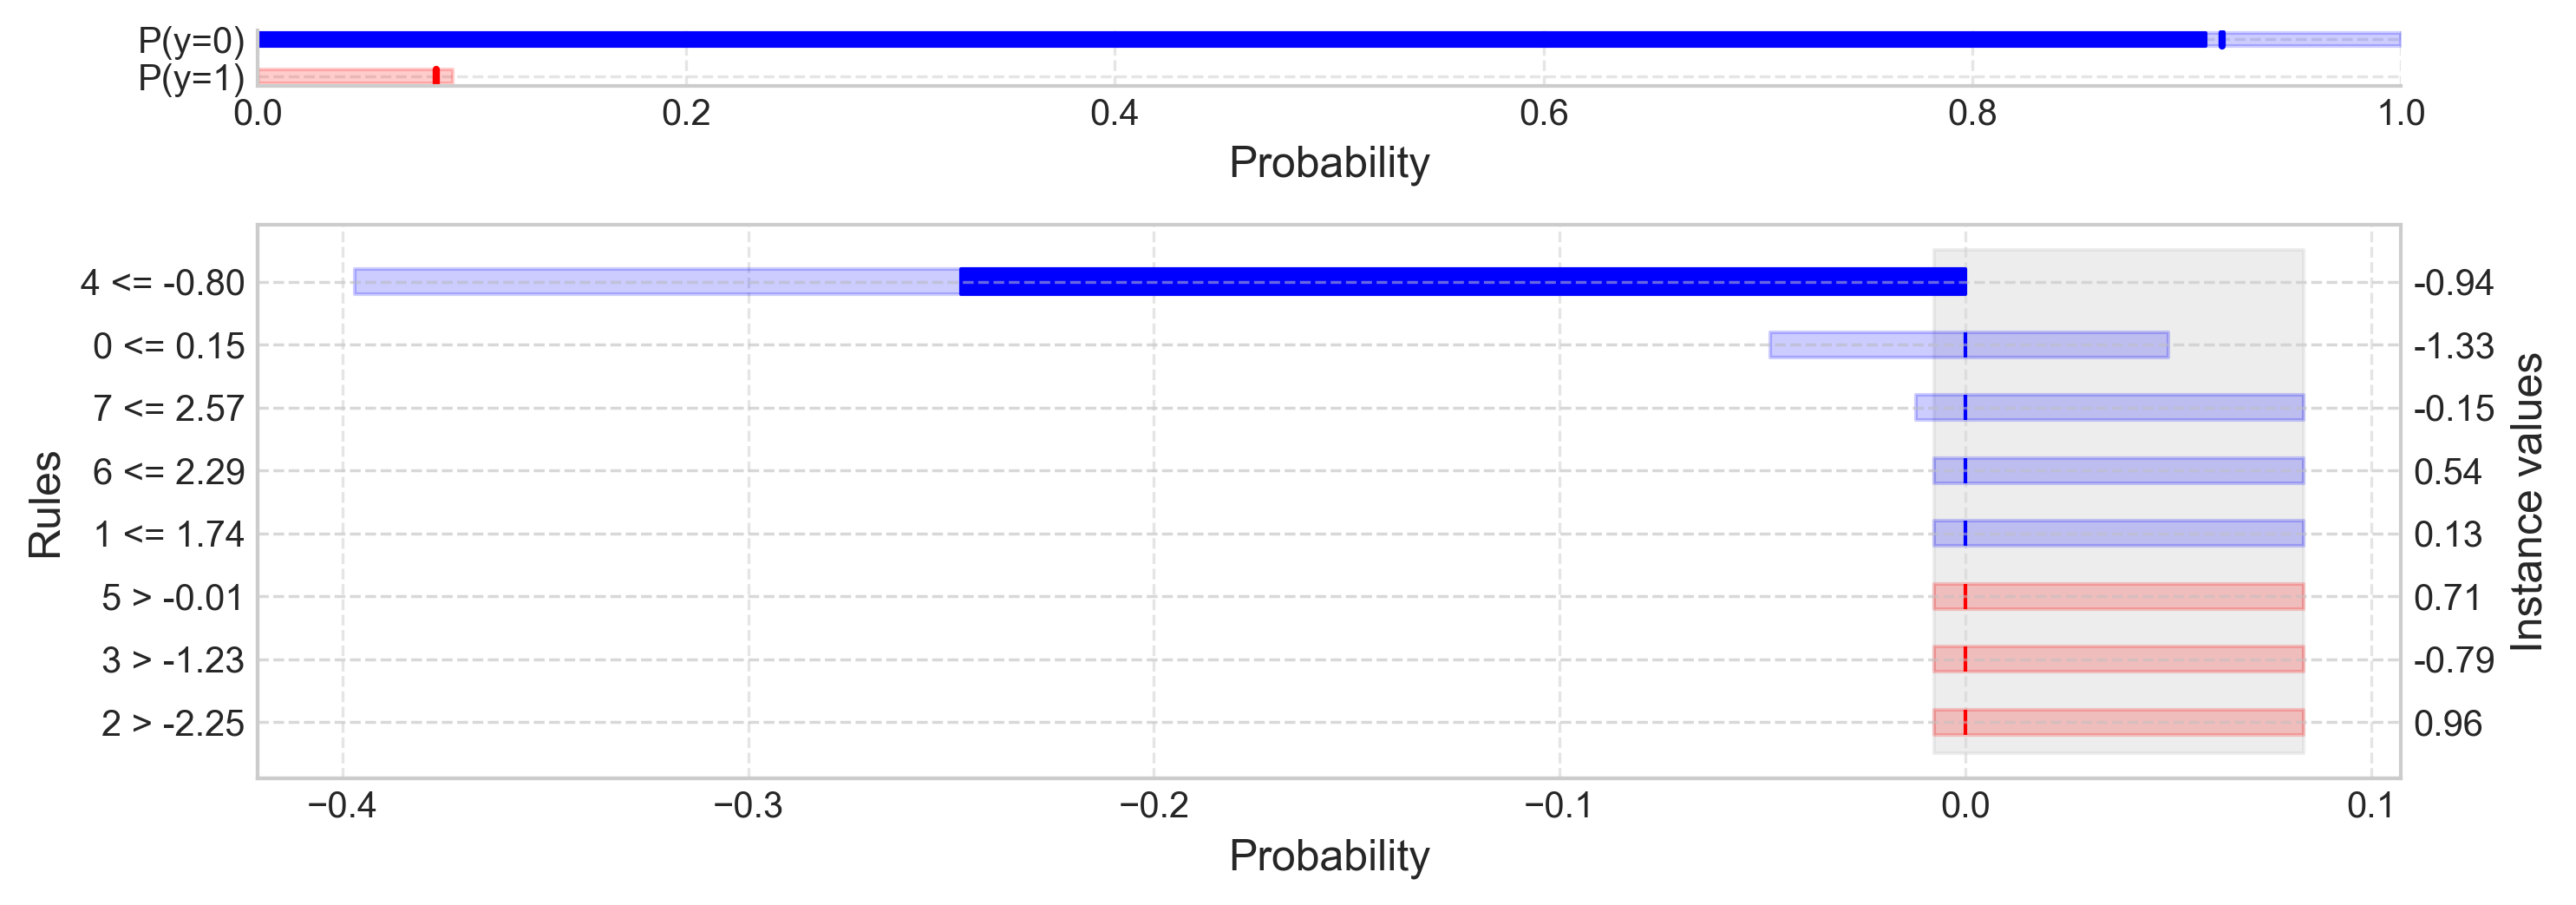

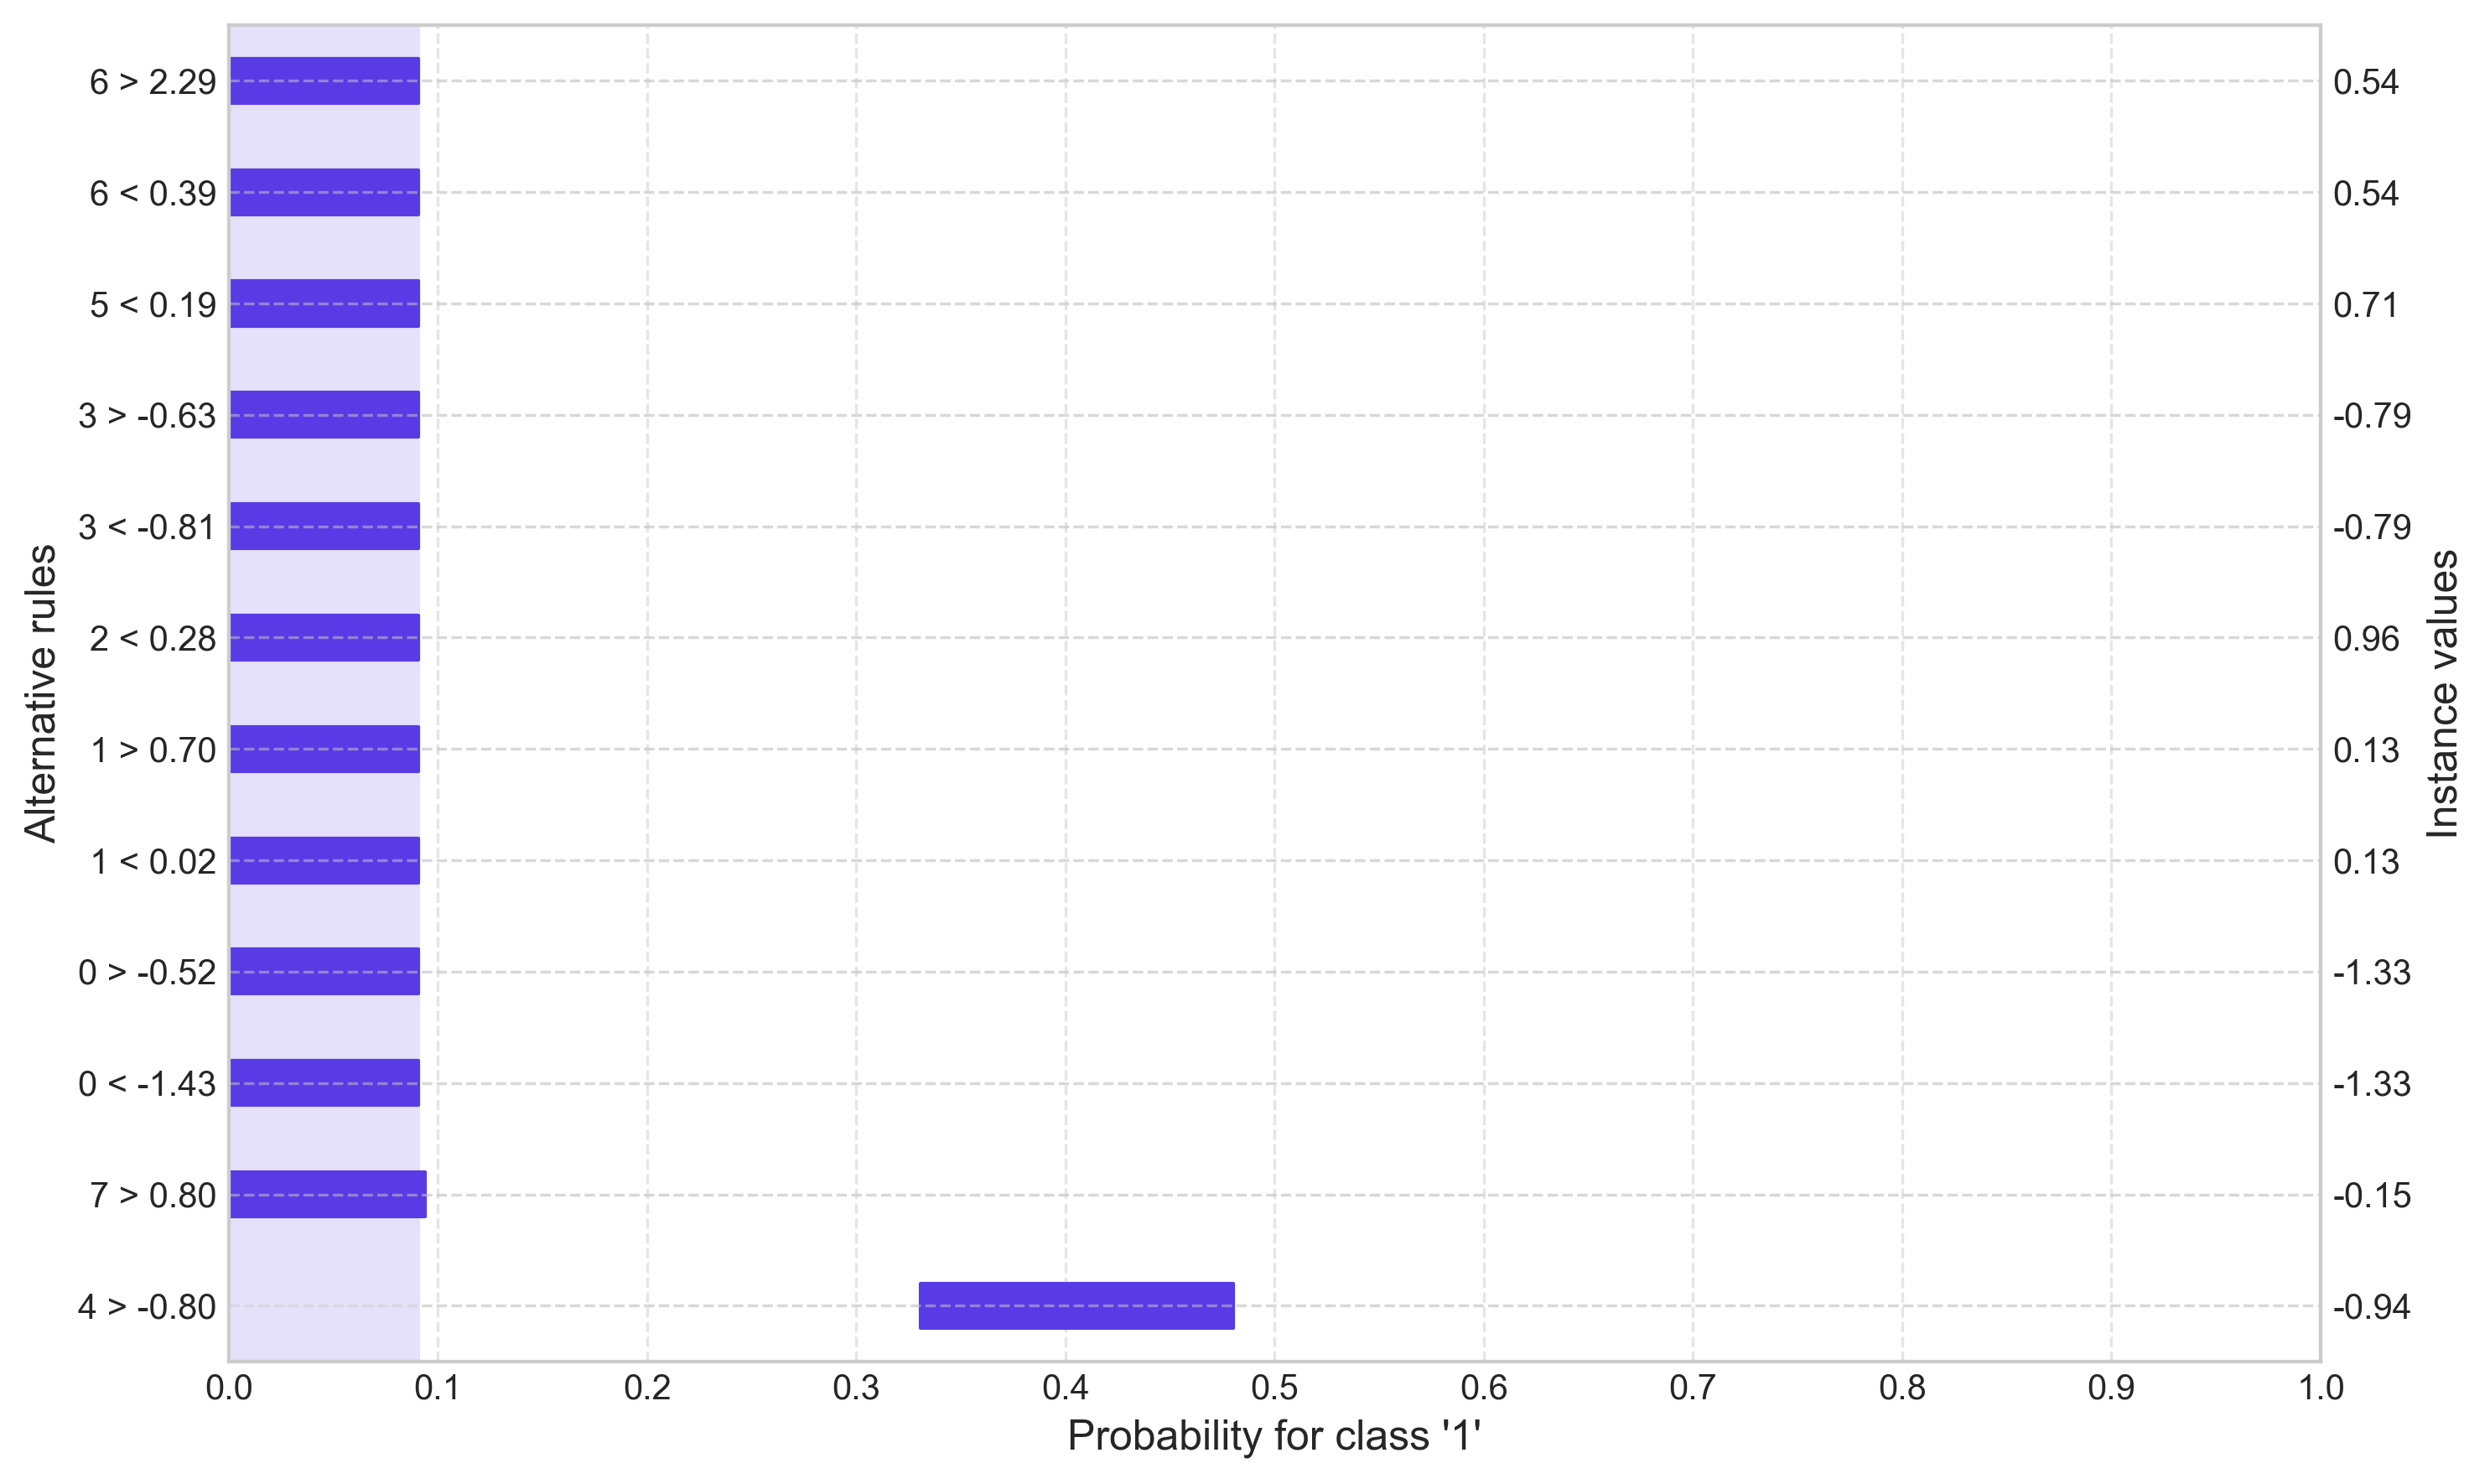

In [17]:
try:
    import xgboost as xgb
except Exception as e:
    print('xgboost not available, skipping XGBoost demo:', e)
else:
    X_train, y_train, X_cal, y_cal, X_test, y_test = make_tiny_binary()
    clf = xgb.XGBClassifier(
        n_estimators=25, max_depth=2, subsample=0.9, colsample_bytree=0.9,
        learning_rate=0.2, tree_method='hist', verbosity=0, random_state=42
    )
    clf.fit(X_train, y_train)

    ce = CalibratedExplainer(clf, X_cal, y_cal, mode='classification')

    # Uncalibrated vs calibrated probabilities
    proba_uncal = ce.predict_proba(X_test, calibrated=False)
    proba_cal, (low, high) = ce.predict_proba(X_test, uq_interval=True)
    print('XGBoost proba_uncal shape:', proba_uncal.shape)
    print('XGBoost proba_cal shape:', proba_cal.shape)
    print('XGBoost first 3 calibrated probs:', proba_cal[:3, 1])
    print('XGBoost first 3 intervals:', list(zip(low[:3], high[:3])))

    y_hat, (y_low, y_high) = ce.predict(X_test, uq_interval=True)
    print('XGBoost first 10 calibrated predictions:', y_hat[:10])
    
    factuals = ce.explain_factual(X_test=X_test[:3])
    factuals[0].plot(uncertainty=True)
    alternatives = ce.explore_alternatives(X_test=X_test[:3])
    alternatives[0].plot()


## LightGBM (LGBMClassifier)

[LightGBM] [Info] Number of positive: 62, number of negative: 58
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516667 -> initscore=0.066691
[LightGBM] [Info] Start training from score 0.066691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\loftuw\AppData\Local\anacon

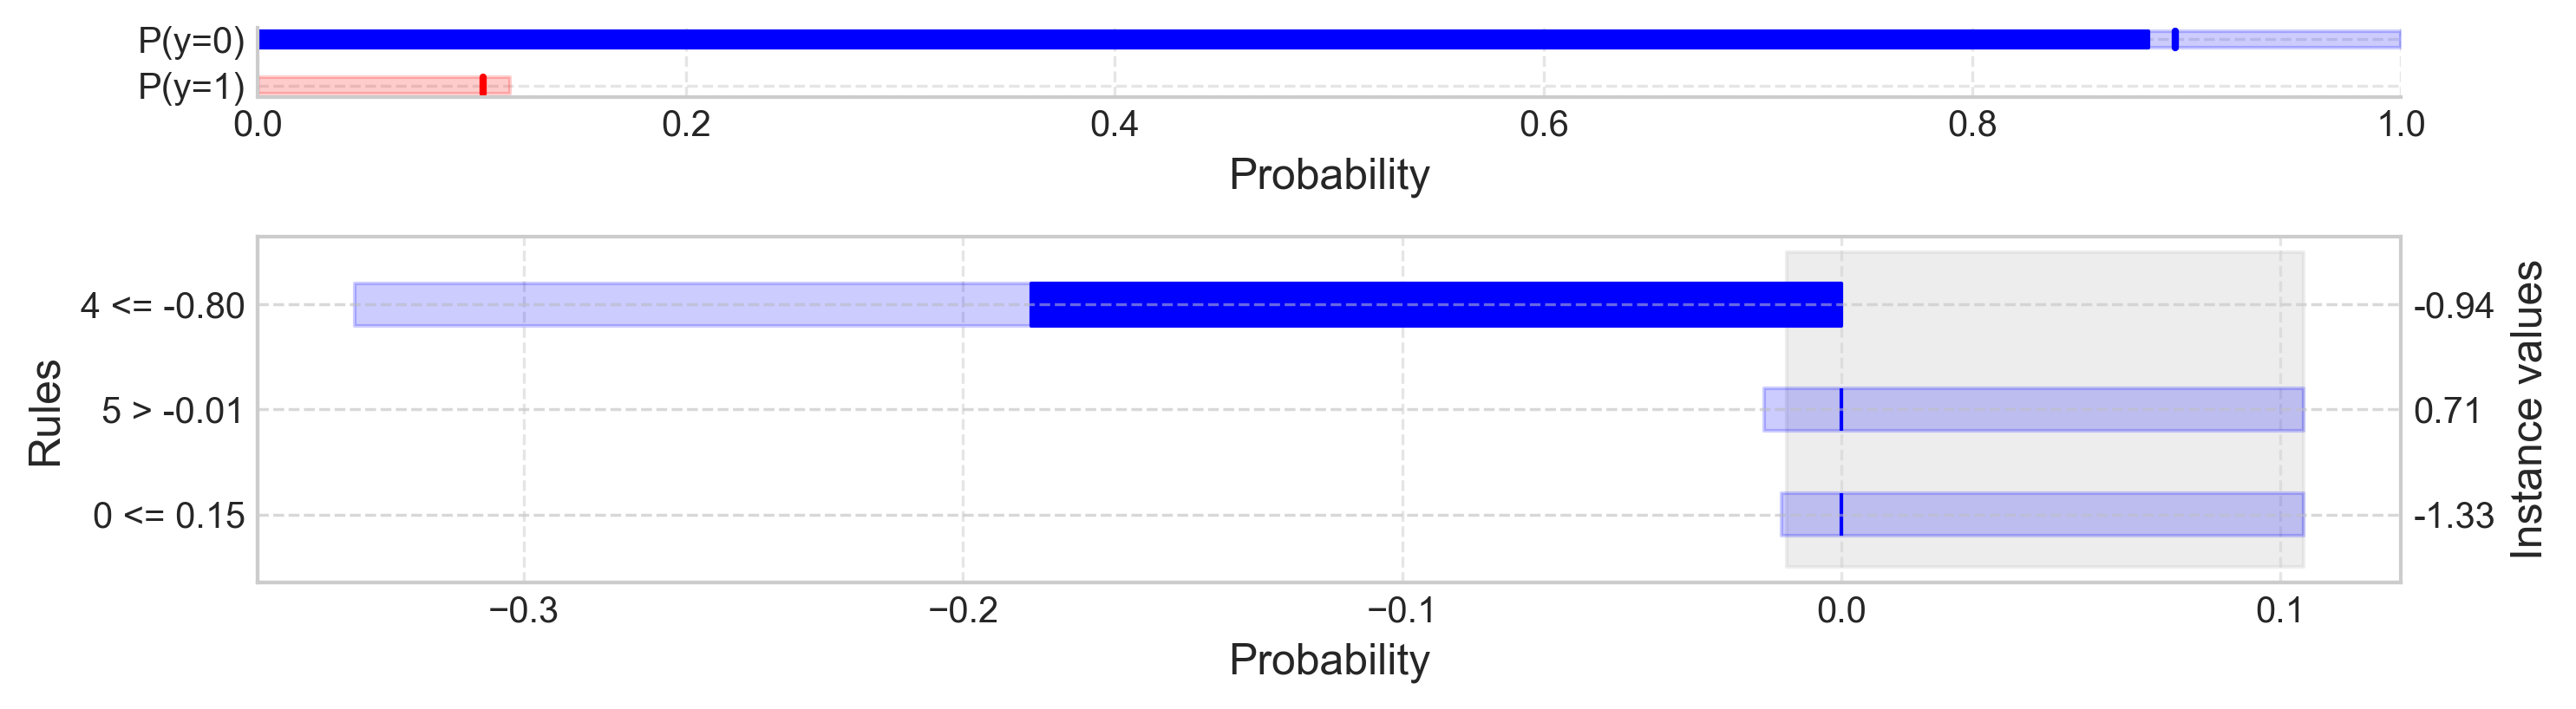

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


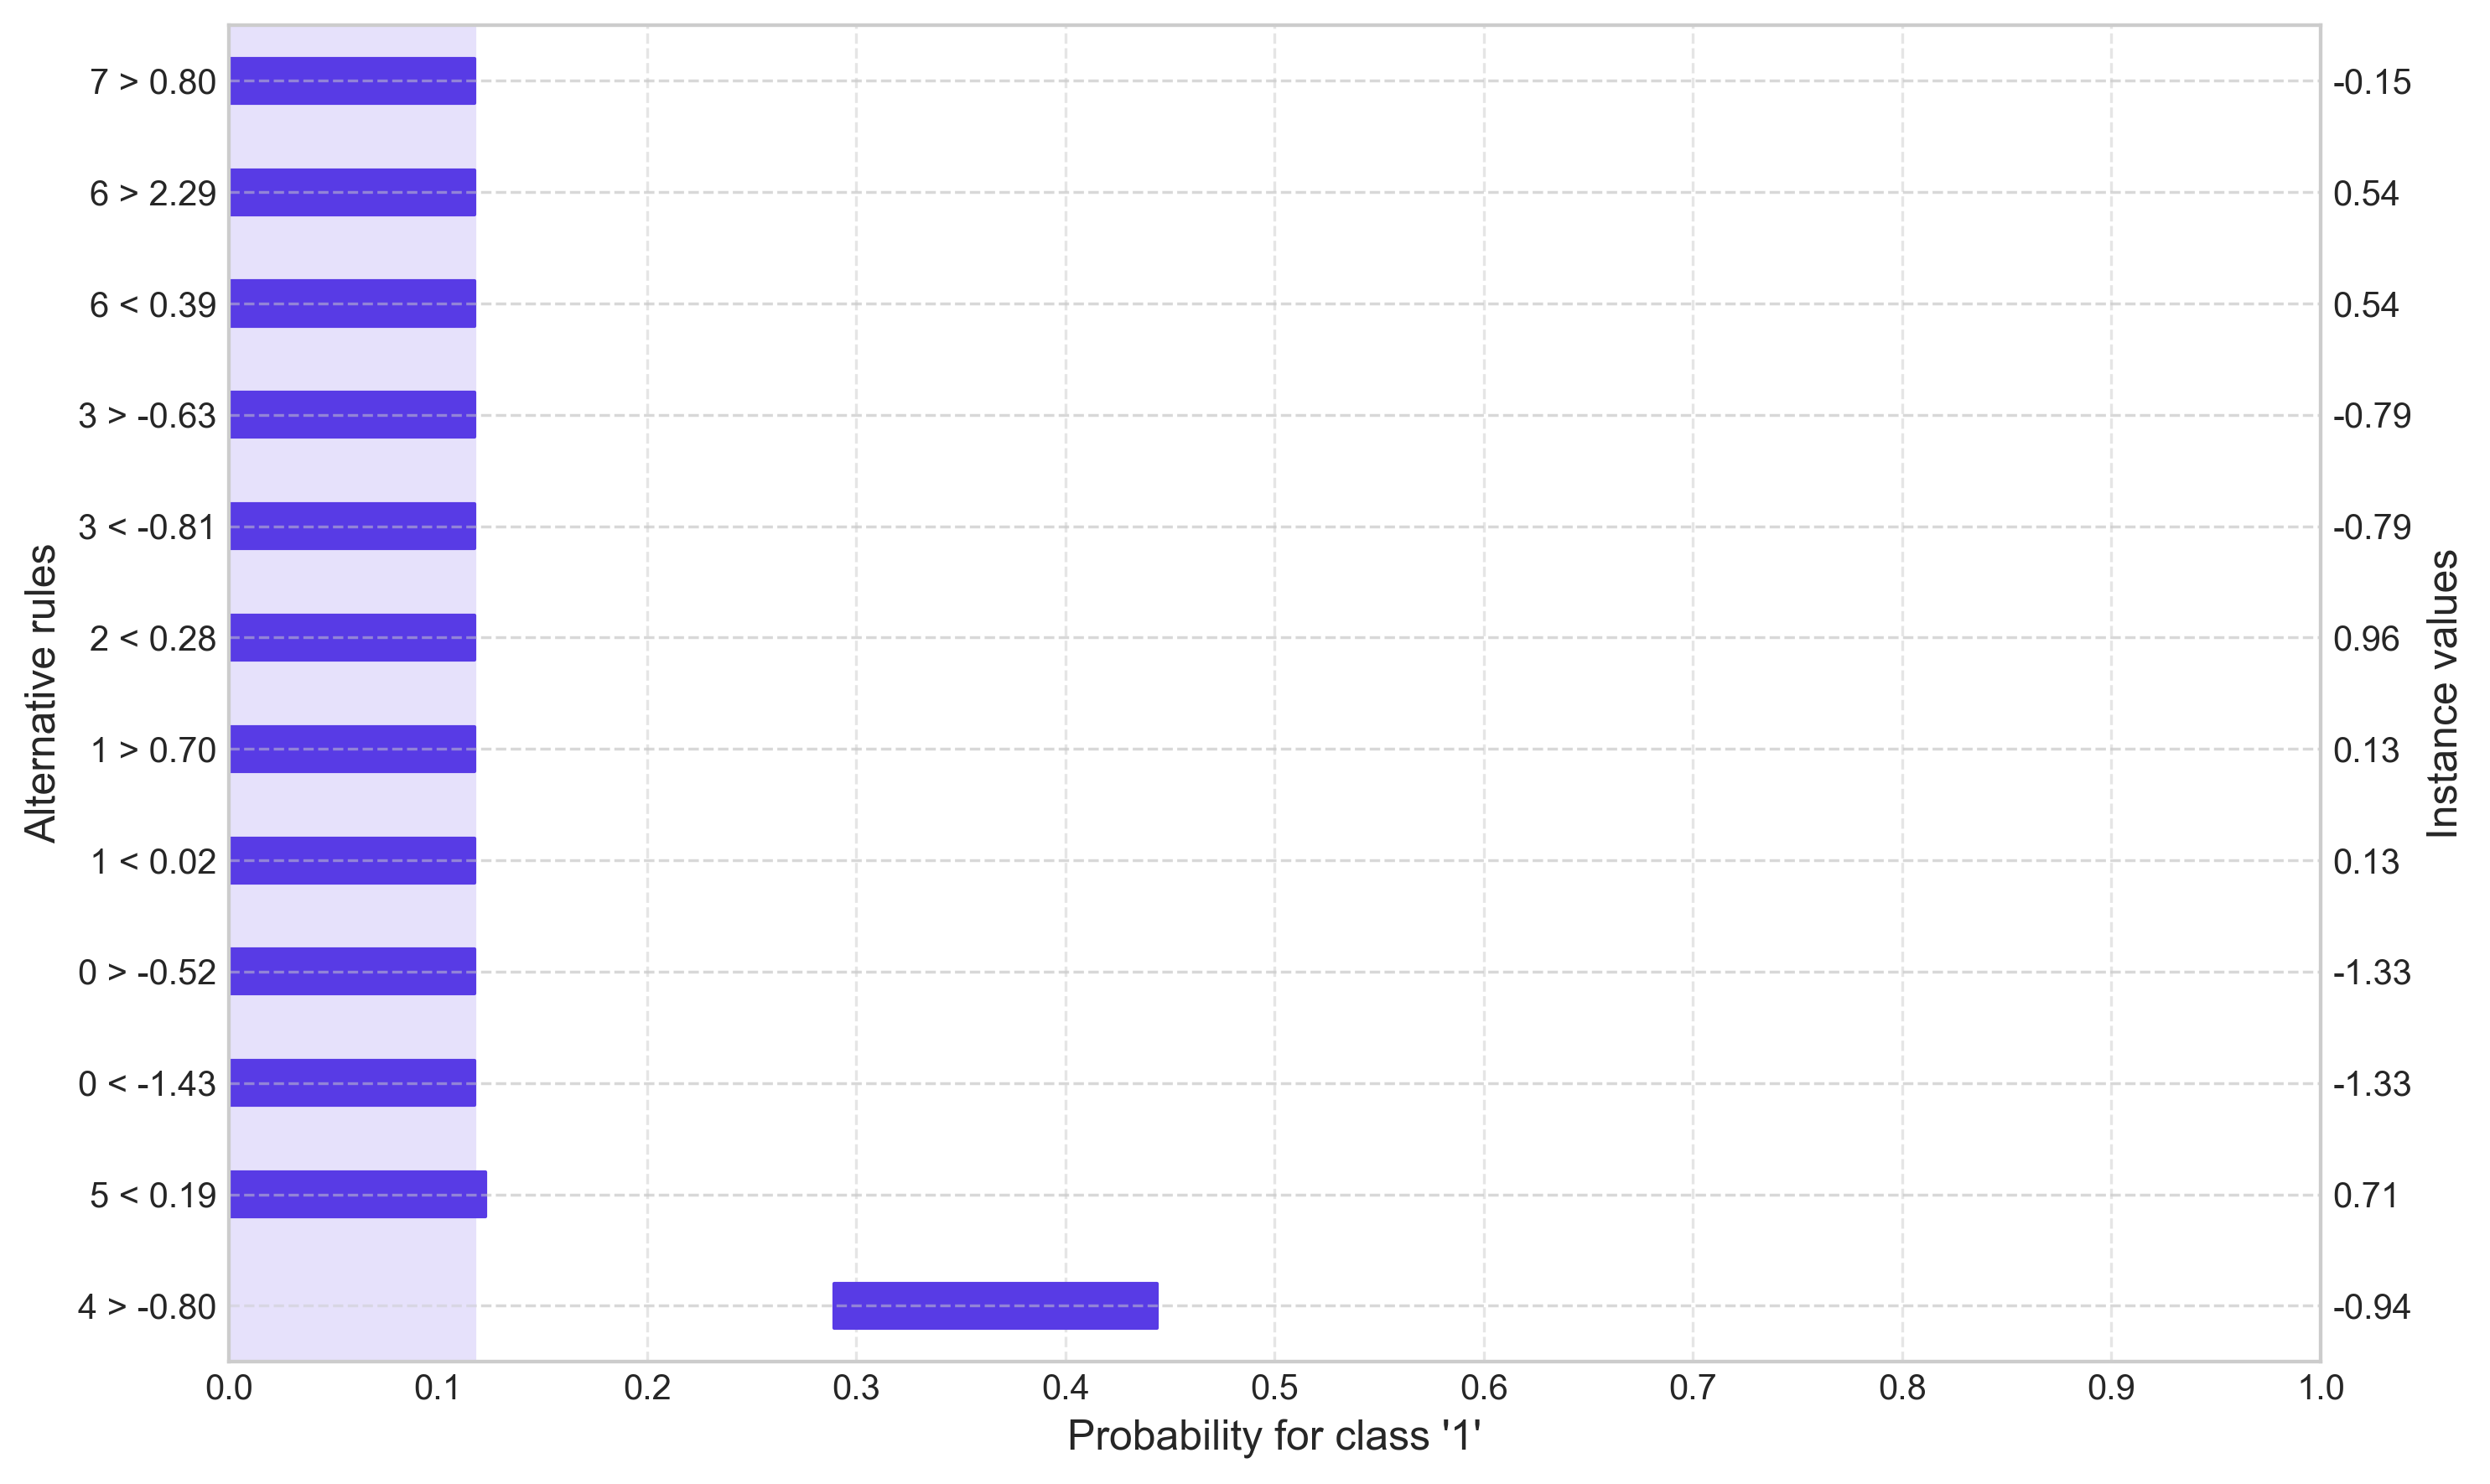

In [18]:
try:
    import lightgbm as lgb
except Exception as e:
    print('lightgbm not available, skipping LightGBM demo:', e)
else:
    X_train, y_train, X_cal, y_cal, X_test, y_test = make_tiny_binary()
    clf = lgb.LGBMClassifier(
        n_estimators=50, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, random_state=42
    )
    clf.fit(X_train, y_train)

    ce = CalibratedExplainer(clf, X_cal, y_cal, mode='classification')
    proba_uncal = ce.predict_proba(X_test, calibrated=False)
    proba_cal, (low, high) = ce.predict_proba(X_test, uq_interval=True)
    print('LightGBM proba_uncal shape:', proba_uncal.shape)
    print('LightGBM first 3 calibrated probs:', proba_cal[:3, 1])
    print('LightGBM first 3 intervals:', list(zip(low[:3], high[:3])))

    y_hat, (y_low, y_high) = ce.predict(X_test, uq_interval=True)
    print('LightGBM first 10 calibrated predictions:', y_hat[:10])
    
    factuals = ce.explain_factual(X_test=X_test[:3])
    factuals[0].plot(uncertainty=True)
    alternatives = ce.explore_alternatives(X_test=X_test[:3])
    alternatives[0].plot()


## CatBoost (CatBoostClassifier)

CatBoost proba_uncal shape: (40, 2)
CatBoost first 3 calibrated probs: [0.15384615 0.17910448 0.85714286]
CatBoost first 3 intervals: [(0.08333333333333333, 0.16666666666666666), (0.08333333333333333, 0.2), (0.8333333333333334, 1.0)]
CatBoost first 10 calibrated predictions: ['0' '0' '1' '0' '1' '0' '1' '0' '1' '1']


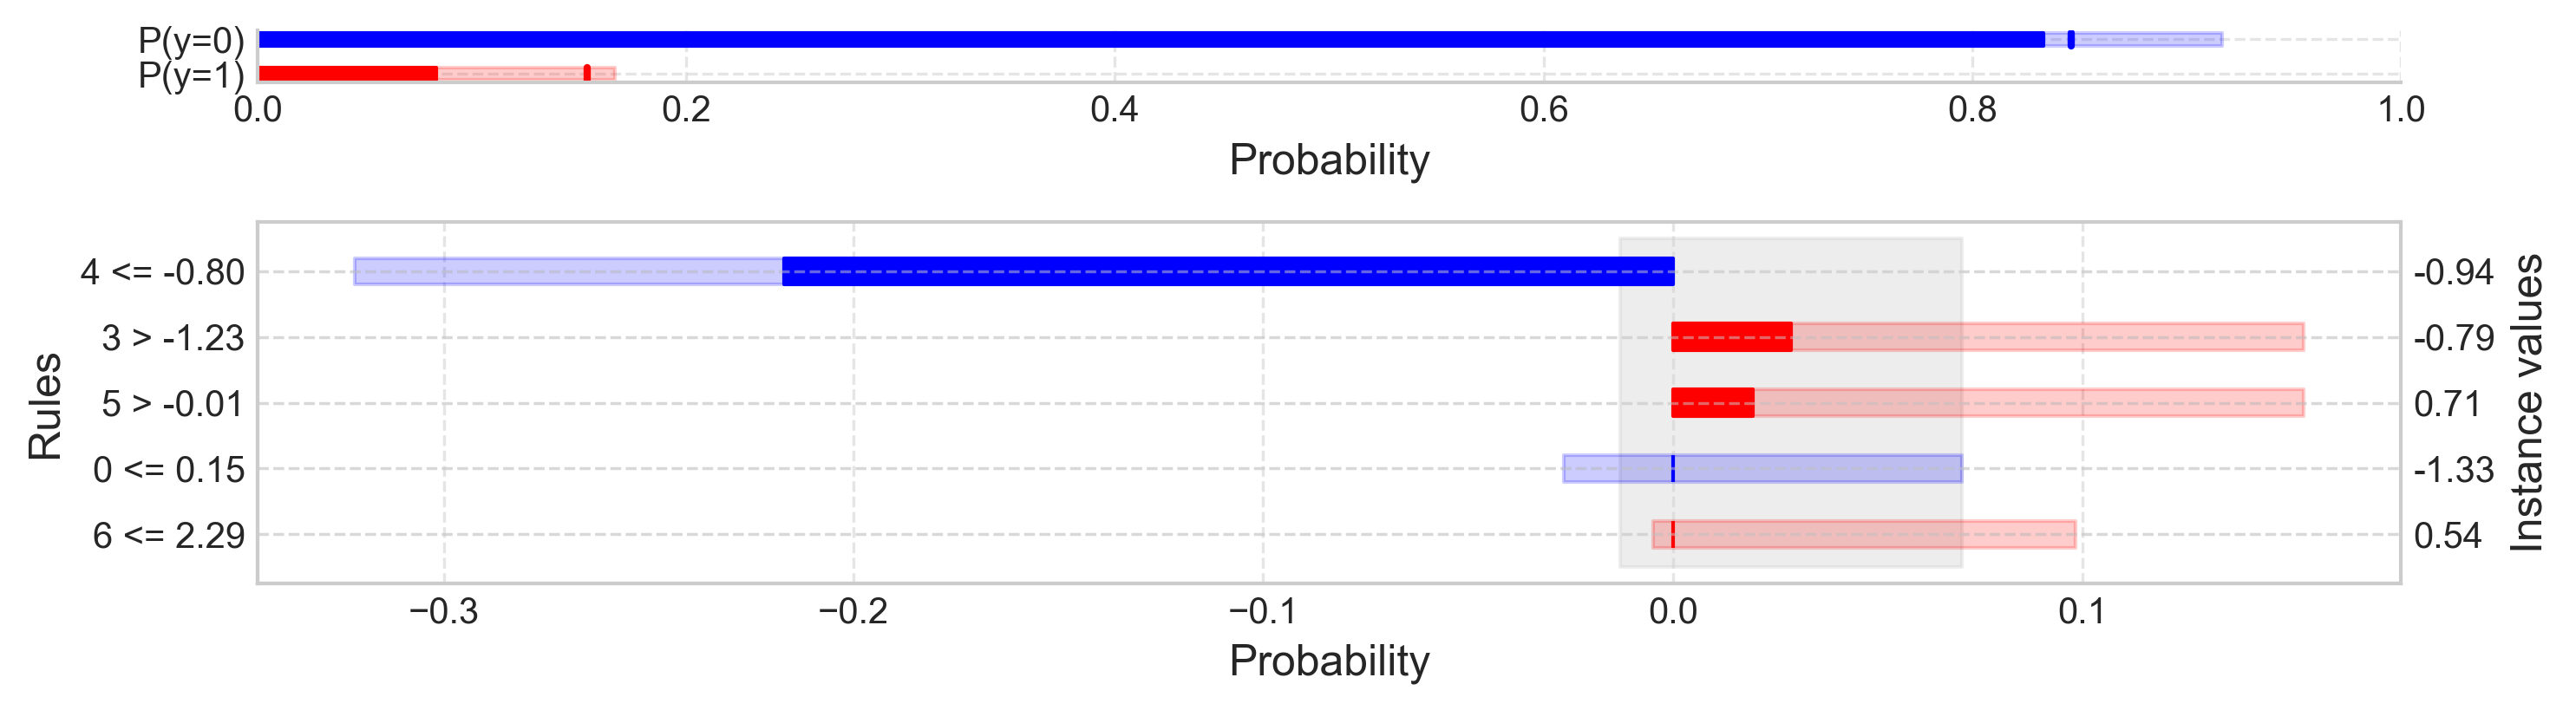

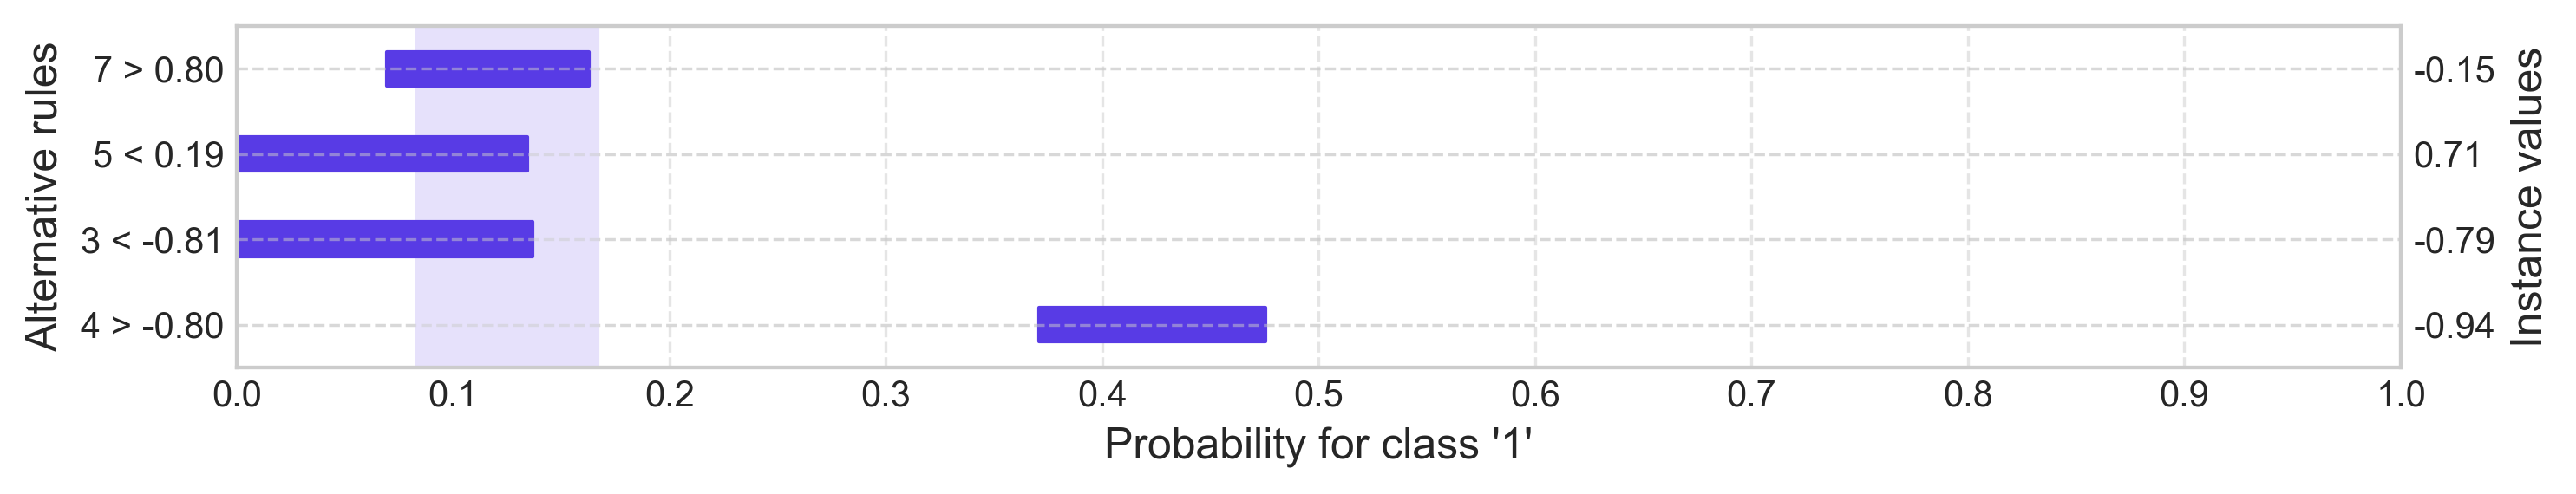

In [19]:
try:
    import catboost as cb
except Exception as e:
    print('catboost not available, skipping CatBoost demo:', e)
else:
    X_train, y_train, X_cal, y_cal, X_test, y_test = make_tiny_binary()
    clf = cb.CatBoostClassifier(iterations=60, depth=4, learning_rate=0.2, loss_function='Logloss', verbose=False, random_seed=42)
    clf.fit(X_train, y_train)

    ce = CalibratedExplainer(clf, X_cal, y_cal, mode='classification')
    proba_uncal = ce.predict_proba(X_test, calibrated=False)
    proba_cal, (low, high) = ce.predict_proba(X_test, uq_interval=True)
    print('CatBoost proba_uncal shape:', proba_uncal.shape)
    print('CatBoost first 3 calibrated probs:', proba_cal[:3, 1])
    print('CatBoost first 3 intervals:', list(zip(low[:3], high[:3])))

    y_hat, (y_low, y_high) = ce.predict(X_test, uq_interval=True)
    print('CatBoost first 10 calibrated predictions:', y_hat[:10])
    
    factuals = ce.explain_factual(X_test=X_test[:3])
    factuals[0].plot(uncertainty=True)
    alternatives = ce.explore_alternatives(X_test=X_test[:3])
    alternatives[0].plot()
